# ML - Final - 2023

## Instruction

- Modify this file to be Final-<Your FirstName-[First Letter of Last Name]>, e.g., <code>Final-Chaklam-S.ipynb</code>
- This exam is open-booked; open-internet, but no interactions with human beings or ChatGPT.
- The completed exams shall be submitted at the virtual learning environment.
- All code should be **complemented with comments**, unless it's really obvious.  **We reserve the privilege to give you zero for any part of the question where the benefit of doubt is not justified**

# Coding

#### Summary
In this section, you will be dealing with a classification problem. You will be generating your own data, training and evaluating them. You will be asked to create a neural network according to the instructions.

The generating data will be a 2d-data `(28, 28)` being arranged similar to the input shape of `nn.Conv2d` with channel = 1, height = 28 and width = 28 `(batch_size, channel, height, width)`

You will then be asked to create a network consisting of 2 `nn.Conv2d` layers followed by a `nn.Linear` layer. After the `nn.Linear` layer, we send the data to a `nn.LSTM` layer where `num_layer` and `hidden_size` can be defined. This `hidden_size` is set to be the same as `num_classes`. The output of lstm is then directly returned.

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

1. Generate a 4 class 2d-data with 70000 samples. (10 points)
- Class 0 data is sampled from a normal distribution with mean = 0, std = 1, size = `(28,28)`
- Class 1 data is sampled from a normal distribution with mean = 5, std = 1, size = `(28,28)`
- Class 2 data is sampled from a normal distribution with mean = 15, std = 1, size = `(28,28)`
- Class 3 data is sampled from a normal distribution with mean = 20, std = 1, size = `(28,28)`

The final shape of *x* should be `(70000, 1, 28, 28)` and *y* should be `(70000,)`

In case you are unable to do question 1, Use the following lines of code to generate your data and continue with question 3. But be aware that no marks will be given to question 1 and question 2

In [2]:
import torchvision
training_data = torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

testing_data  = torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

2. Split your data into train and test with the split ratio of 1/7 (5 points)

In [3]:
# split with a ratio of 3/7 with 30% of dataset used for testing 
# train_set, test_set = torch.utils.data.random_split(train_data, [60000, 10000])

3. Check the size of your train and test sets (5 points)

In [4]:
# train_set.shape, test_set.shape
len(training_data), len(testing_data)

(60000, 10000)

4. Set up your train and test loader with a batch size of 32 and `shuffle = True` (10 points)

In [5]:
# setting manual seed and dataloaders
torch.manual_seed(42)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(testing_data, batch_size=32, shuffle=True)

5. Check the shape of your batch. It should be `[batchsize = 32, channel = 1, height = 28, width = 28]` (5 points)

In [6]:
# shape of batch
for sample, label in train_loader:
    break
sample.shape

torch.Size([32, 1, 28, 28])

6. Plot 6 samples of any classes (10 points)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [1 2 8 5 2 6]
Class: 1 - one 2 - two 8 - eight 5 - five 2 - two 6 - six 9 - nine 9 - nine 9 - nine 4 - four


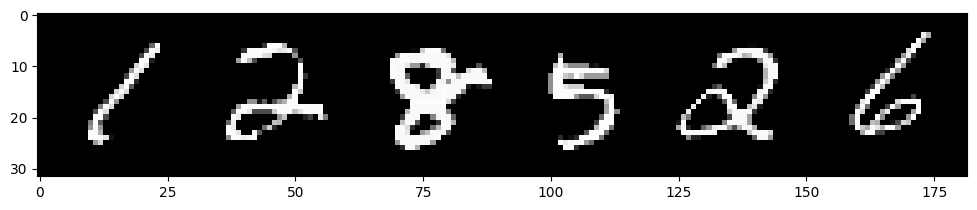

In [7]:
class_names = training_data.classes
# Print the labels
print('Label:', label[0:6].numpy())
print('Class:', *np.array([class_names[i] for i in label[0:10]]))

im = make_grid(sample[0:6], nrow=8)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

If you use MNIST

7. Configure your device. (5 points)

In [8]:
#We can check whether we have gpu
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device: ", device)

Device:  cuda:0


8. Define your class called `Net` with the following layers (40 points)
- cnn2d layer 1 with `in_channel = 1`, `out_channel = 10`, `kernel size = 5`, dropout of `p = 0.5`, `maxpool` and `relu` as its activation function
- cnn2d layer 2 with `in_channel = 10`, `out_channel = 20`, `kernel size = 5`, dropout of `p = 0.5`, `maxpool` and `relu` as its activation function
- linear layer with output of 25
- lstm with `num_layer = 2` and set hidden size to be num_classes




In [9]:
class Net(nn.Module):
    def __init__(self, num_layers = 2, num_classes = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(4*4*20, 25)
        self.lstm = nn.LSTM(input_size=25, hidden_size=num_classes, num_layers=num_layers) 

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.dropout1(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = self.dropout2(X)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 4*4*20)
        X = F.relu(self.fc1(X))
        X, _ = self.lstm(X)
        return X

9. Create a model object with `num_layers of lstm = 2`, `hidden_size` and `num_classes = 4` (10 points)

If you use MNIST hidden_size and  `num_classes = 10`


In [10]:
# instantiating model object and sending it to gpu
model = Net(num_layers=2, num_classes=10)
model = model.to(device)
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=25, bias=True)
  (lstm): LSTM(25, 10, num_layers=2)
)

10. Define an appropriate loss function for classification of this dataset (2.5 points)

In [11]:
# cross entropy loss since this is a classification problem
criterion = nn.CrossEntropyLoss()

11. Define your optimizer as `Adam` with learning rate of `0.001` (5 points)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

12. Define your train function and train your model with `n_epoch = 3` (15 points)

In [13]:
# number of epochs
n_epoch = 3

# time function for tracking training time
import time
start_time = time.time()

# list to store loss and correct predictions for plotting
train_losses = []
train_correct = []

for epoch in range(n_epoch):
    # set correct predictions of current epoch to zero
    trn_corr = 0

    # loop through batches
    for images, labels in train_loader:
        # send x, y to gpu
        images = images.to(device)
        labels = labels.to(device)

        # prediction
        yhat = model(images)

        # store correct predictions
        predicted = torch.max(yhat.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr

        # loss
        loss = criterion(yhat, labels)

        # reset gradients
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # updating weights
        optimizer.step()
    
    # print epoch loss/ accuracy
    print(f"Epoch:{epoch} : Loss: {loss} : accuracy: {trn_corr.item()*100/len(training_data):7.3f}%")

    # store loss and accuracy in predefined list
    train_losses.append(loss)
    train_correct.append(trn_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:0 : Loss: 1.0686787366867065 : accuracy:  80.595%
Epoch:1 : Loss: 1.0734281539916992 : accuracy:  95.413%
Epoch:2 : Loss: 0.9978872537612915 : accuracy:  96.445%

Duration: 32 seconds


13. Plot your train losses and accuracies (10 points)

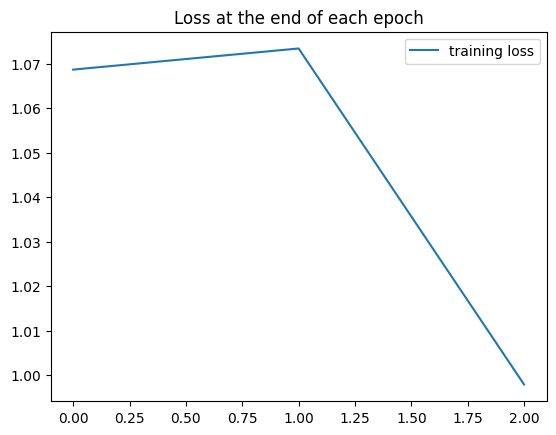

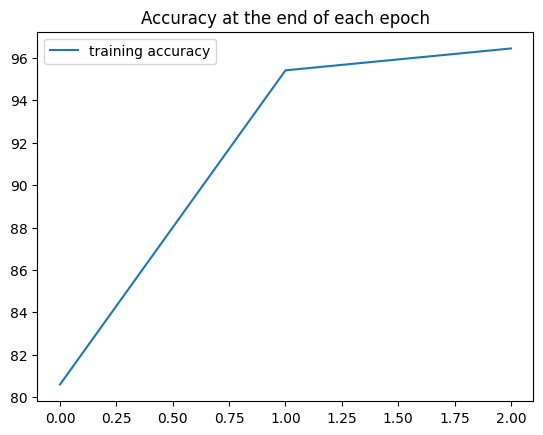

In [14]:
# plot of loss over 3 epochs
train_losses = [loss.cpu().data for loss in train_losses]
plt.figure(1)
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.legend();

# plot of accuracy over 3 epochs
train_accuracy = [acc.item() / len(training_data) * 100 for acc in train_correct]
plt.figure(2)
plt.plot(train_accuracy, label='training accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

plt.show()

14. Evaluate your model with your test set (10 points)

In [15]:
# set model to eval mode to turn dropout to eval mode
model.eval()

# stop calculation of gradients (computational efficiency)
with torch.no_grad():
    correct = 0
    for sample, label in test_loader:
        sample = sample.to(device)
        label = label.to(device)
        yhat = model(sample)
        predicted = torch.max(yhat,1)[1]
        correct += (predicted == label).sum()
print(f'Test accuracy: {correct.item()}/{len(testing_data)} = {correct.item()*100/(len(testing_data)):7.3f}%')
        

Test accuracy: 9798/10000 =  97.980%
